Brief Conceptual Overview:
1. Choose a 'Content' image
2. Chosse a 'Style' image
3. Pass through a Pretrained CNN model
4. Compute the feature maps of the content image
5. To extract the style we use a transformation of the features called the Gram matrix.
6. Combine the two streams of data.



The style Transfer Algorithm:
1. Trainable random noise
2. Pick a pretrained CNN network
3. Match Content ("pixel-level" feature mapping)
4. Match Style ("texture-level" feature mapping)

Detailed Style Transfer Algorithm

<u>Preparation</u>
1. Import and Freeze a pretrained CNN
2. Import and transform images.
3. Make a trainable target image using random numbers.
4. Functions to compute feature maps and Gram matrices.

<u>Training (Loop over N epochs)</u>
1. Extract target feature activation maps.
2. Compute 'ContentMSE': Target feature maps vs Content feature maps
3. Compute Gram
    1. Target feature maps
    2. Style feature maps<br><br>
4. Compute 'StyleMSE': Target Gram vs Style Gram
5. Compute Loss = ContentMSE + StyleMSE
6. Backprop on Target Image

In [1]:
# Import libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from imageio.v3 import imread

import numpy as np

import matplotlib.pyplot as plt

In [2]:
# import the model
vgg = torchvision.models.vgg19(weights='IMAGENET1K_V1')

# Freeze all layers
for p in vgg.parameters():
    p.requires_grad = False

# set to evaluation mode
vgg.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 75.7MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [3]:
# Send the network to the GPU if available
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [48]:
from PIL import Image
content_img = imread("style-transfer.jpg")
style_img = imread("https://thumbs.dreamstime.com/b/halftone-abstract-rainbow-colored-background-195058343.jpg")

# content_img = content_img.convert("RGB")

# Initialize the target image and random numbers
target_img = np.random.randint(low=0, high=255, size=content_img.shape, dtype=np.uint8)

print(content_img.shape)
print(target_img.shape)
print(style_img.shape)

(1080, 1080, 3)
(1080, 1080, 3)
(800, 800, 3)


In [49]:
# Create the Transform
transforms = T.Compose([
    T.ToTensor(),
    T.Resize(800, antialias=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply them to the images ("Unsqueeze to make them a 4D tensor") and push to GPU
content_img = transforms(content_img).unsqueeze(0).to(device)
style_img = transforms(style_img).unsqueeze(0).to(device)
target_img = transforms(target_img).unsqueeze(0).to(device)

print(content_img.shape)
print(target_img.shape)
print(style_img.shape)

torch.Size([1, 3, 800, 800])
torch.Size([1, 3, 800, 800])
torch.Size([1, 3, 800, 800])


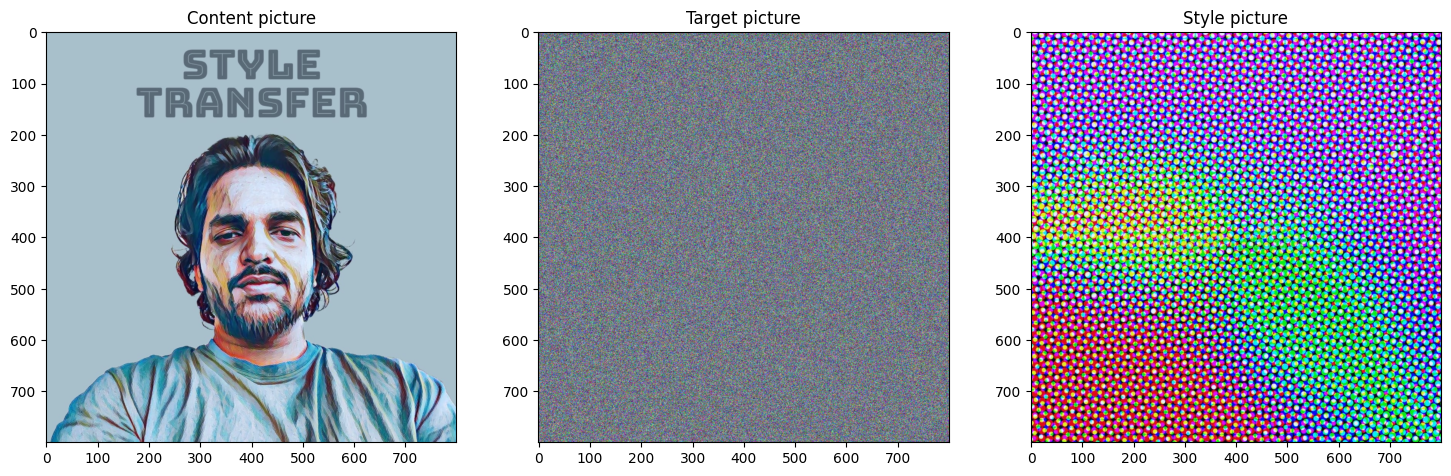

In [50]:
# Let's look at the "before" pics
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

pic = content_img.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic))/(np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title("Content picture")

pic = target_img.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic))/(np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title("Target picture")

pic = style_img.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic))/(np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title("Style picture")

plt.show()

In [51]:
def get_fm_acts(img, net):
    """
    A function that returns feature maps.
    """
    # Initialize feature maps as a list
    feature_maps = []
    feature_names = []

    conv_layer_idx = 0

    # Loop through all layers in the "features" block
    for layernum in range(len(net.features)):

        # Print out info from this layer
        # print(layernum, net.features[layernum])

        # Process the image through this layer
        img = net.features[layernum](img)

        # Store the image if it's a conv2d layer
        if 'Conv2d' in str(net.features[layernum]):
            feature_maps.append(img)
            feature_names.append('ConvLayer_' + str(conv_layer_idx))
            conv_layer_idx += 1

    return feature_maps, feature_names

In [52]:
def gram_matrix(M):
    """
    A function that returns the Gram Matrix of the feature activation maps.
    """
    # Reshape to 2D
    _, chans, height, width = M.shape
    M = M.reshape(chans, height*width)

    # Compute and return covariance matrix
    gram = torch.mm(M, M.t())/(chans*height*width)
    return gram

In [53]:
# Inspect the output of the function
featmaps, featnames = get_fm_acts(content_img, vgg)

# Print out some info
for i in range(len(featnames)):
    print("Feature map '%s' is size %s"%(featnames[i], (featmaps[i].shape)))

Feature map 'ConvLayer_0' is size torch.Size([1, 64, 800, 800])
Feature map 'ConvLayer_1' is size torch.Size([1, 64, 800, 800])
Feature map 'ConvLayer_2' is size torch.Size([1, 128, 400, 400])
Feature map 'ConvLayer_3' is size torch.Size([1, 128, 400, 400])
Feature map 'ConvLayer_4' is size torch.Size([1, 256, 200, 200])
Feature map 'ConvLayer_5' is size torch.Size([1, 256, 200, 200])
Feature map 'ConvLayer_6' is size torch.Size([1, 256, 200, 200])
Feature map 'ConvLayer_7' is size torch.Size([1, 256, 200, 200])
Feature map 'ConvLayer_8' is size torch.Size([1, 512, 100, 100])
Feature map 'ConvLayer_9' is size torch.Size([1, 512, 100, 100])
Feature map 'ConvLayer_10' is size torch.Size([1, 512, 100, 100])
Feature map 'ConvLayer_11' is size torch.Size([1, 512, 100, 100])
Feature map 'ConvLayer_12' is size torch.Size([1, 512, 50, 50])
Feature map 'ConvLayer_13' is size torch.Size([1, 512, 50, 50])
Feature map 'ConvLayer_14' is size torch.Size([1, 512, 50, 50])
Feature map 'ConvLayer_15' i

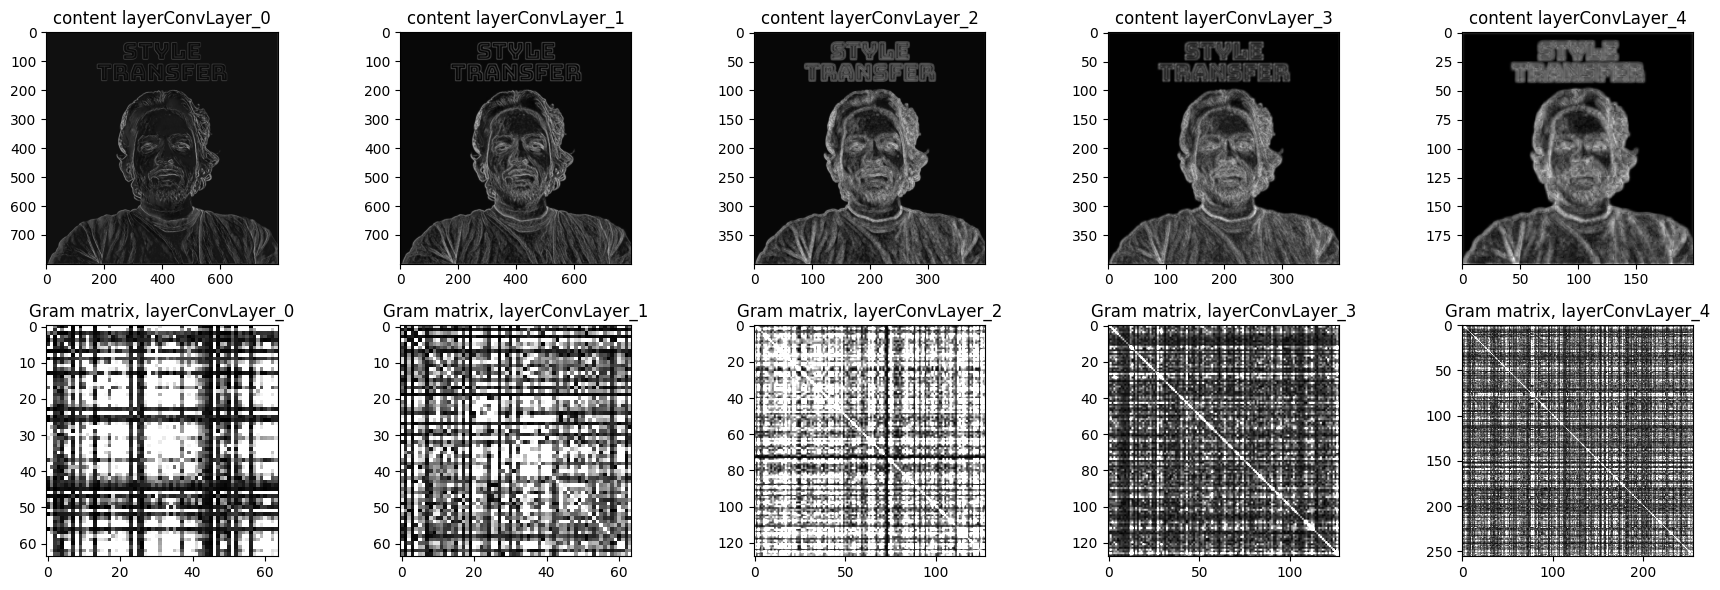

In [54]:
# 'Content' Image looks like
content_fmaps, content_fnames = get_fm_acts(content_img, vgg)

fig, axs = plt.subplots(2, 5, figsize=(18, 6))
for i in range(5):

    # Average over all feature maps from this layer, and normalize
    pic = np.mean(content_fmaps[i].cpu().squeeze().numpy(), axis=0)
    pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

    axs[0, i].imshow(pic, cmap='gray')
    axs[0, i].set_title('content layer' + str(content_fnames[i]))

    # Now the gram matrix
    pic = gram_matrix(content_fmaps[i]).cpu().numpy()
    pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

    axs[1, i].imshow(pic, cmap='gray', vmax=0.1)
    axs[1, i].set_title('Gram matrix, layer' + str(content_fnames[i]))

plt.tight_layout()
plt.show()

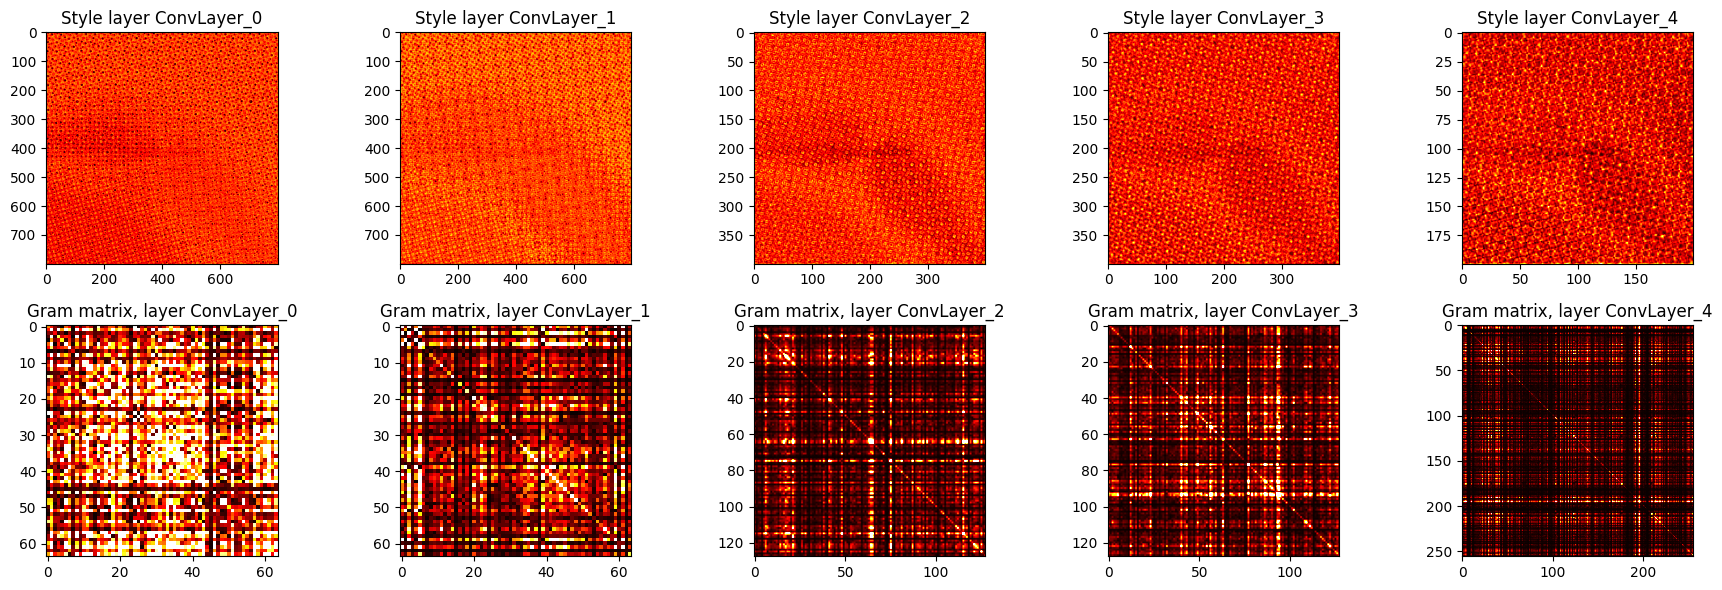

In [55]:
# repeat for the style image

style_fmaps, style_fnames = get_fm_acts(style_img, vgg)

fig, axs = plt.subplots(2, 5, figsize=(18, 6))
for i in range(5):

    # Average over all feature maps from this layer, and normalize
    pic = np.mean(style_fmaps[i].cpu().squeeze().numpy(), axis=0)
    pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

    axs[0, i].imshow(pic, cmap='hot')
    axs[0, i].set_title('Style layer ' + str(style_fnames[i]))

    # Now the gram matrix
    pic = gram_matrix(style_fmaps[i]).cpu().numpy()
    pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

    axs[1, i].imshow(pic, cmap='hot', vmax=0.1)
    axs[1, i].set_title('Gram matrix, layer ' + str(style_fnames[i]))

plt.tight_layout()
plt.show()

In [74]:
# Which layers to use
content_layers = ['ConvLayer_0']
style_layers = ['ConvLayer_0', 'ConvLayer_1', 'ConvLayer_2']
style_weights = [1, 0.4, 0.3]

In [75]:
# Make a copy of the target image and push to GPU
target = target_img.clone()
target.requires_grad = True
target = target.to(device)
STYLE_SCALING = 3e2

# Number of epochs to train
numepochs = 1500

# Optimizer for backprop
optimizer = torch.optim.RMSprop([target], lr=0.005)

for epoch in range(numepochs):

    # Extract the target feature maps
    target_fmaps, target_fnames = get_fm_acts(target, vgg)

    # Initialize the individual loss component
    style_loss = 0
    content_loss = 0

    # Loop over layers
    for layer in range(len(target_fnames)):

        # Compute the content loss
        if target_fnames[layer] in content_layers:
            content_loss += torch.mean((target_fmaps[layer] - content_fmaps[layer])**2)

        # Compute the style loss
        if target_fnames[layer] in style_layers:

            # Gram matrices
            Gtarget = gram_matrix(target_fmaps[layer])
            Gstyle = gram_matrix(style_fmaps[layer])

            # Compute their loss (de-weighted with increasing depth)
            style_loss += torch.mean((Gtarget-Gstyle)**2) * style_weights[style_layers.index(target_fnames[layer])]

    # Combined Loss
    comb_loss = STYLE_SCALING*style_loss + content_loss

    # backprop
    optimizer.zero_grad()
    comb_loss.backward()
    optimizer.step()
    print(f"Epoch{epoch+1}/{numepochs}")

Epoch1/1500
Epoch2/1500
Epoch3/1500
Epoch4/1500
Epoch5/1500
Epoch6/1500
Epoch7/1500
Epoch8/1500
Epoch9/1500
Epoch10/1500
Epoch11/1500
Epoch12/1500
Epoch13/1500
Epoch14/1500
Epoch15/1500
Epoch16/1500
Epoch17/1500
Epoch18/1500
Epoch19/1500
Epoch20/1500
Epoch21/1500
Epoch22/1500
Epoch23/1500
Epoch24/1500
Epoch25/1500
Epoch26/1500
Epoch27/1500
Epoch28/1500
Epoch29/1500
Epoch30/1500
Epoch31/1500
Epoch32/1500
Epoch33/1500
Epoch34/1500
Epoch35/1500
Epoch36/1500
Epoch37/1500
Epoch38/1500
Epoch39/1500
Epoch40/1500
Epoch41/1500
Epoch42/1500
Epoch43/1500
Epoch44/1500
Epoch45/1500
Epoch46/1500
Epoch47/1500
Epoch48/1500
Epoch49/1500
Epoch50/1500
Epoch51/1500
Epoch52/1500
Epoch53/1500
Epoch54/1500
Epoch55/1500
Epoch56/1500
Epoch57/1500
Epoch58/1500
Epoch59/1500
Epoch60/1500
Epoch61/1500
Epoch62/1500
Epoch63/1500
Epoch64/1500
Epoch65/1500
Epoch66/1500
Epoch67/1500
Epoch68/1500
Epoch69/1500
Epoch70/1500
Epoch71/1500
Epoch72/1500
Epoch73/1500
Epoch74/1500
Epoch75/1500
Epoch76/1500
Epoch77/1500
Epoch78/

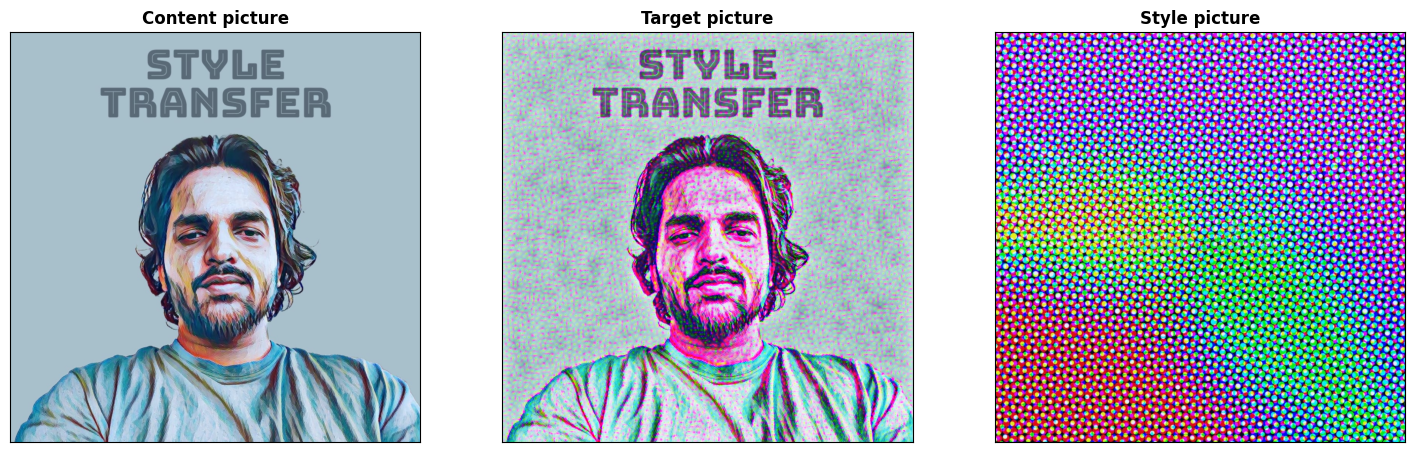

In [76]:
# The "after" pic
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

pic = content_img.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic))/(np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title("Content picture", fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title("Target picture", fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = style_img.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic))/(np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title("Style picture", fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

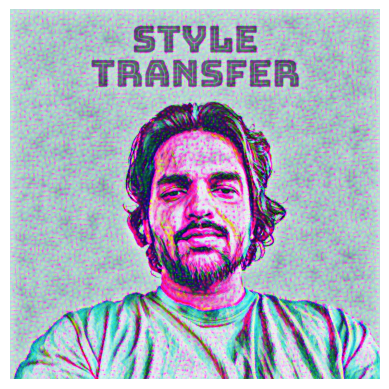

In [77]:
# The "after" pic
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
plt.imshow(pic)
plt.axis('off')
plt.show()